### Import Libraries

In [150]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
from scipy.linalg import block_diag

import time

import matplotlib.pyplot as plt

### Set Parameters

In [151]:
a = 2              # Length of rectangle in x direction 
b = 1             # Length of rectangle in y direction 
R = 1             # Radius of circle

maxh = 0.1   # Mesh-size
order = 4      # Order of Polynomials
nr_eigs = 200    # Number of Eigenvalues to approximate

### Create the Rectangle

In [152]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

### finite element space and bilinear form

In [153]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

print(fes.ndof)


3769


### eigenvalue solver via scipy

In [154]:
shift = 3

shifted = a.mat.CreateMatrix()
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())
print(a.mat.height)
tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()
def matvec(v):
    tmp1.FV().NumPy()[:] = v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)
mu, vecs = scipy.sparse.linalg.eigs(A,nr_eigs)

lamsquared=shift**2+1/mu
lamsquared = sorted(lamsquared)
lams=[sqrt(l) for l in lamsquared]
print("resonances:")
for i in range (0,len(lams)):
    print(i,": ",lams[i], " squared: ", lamsquared[i])  


3769
resonances:
0 :  2.421152116249788e-07  squared:  (5.861977570020827e-14-4.4621961411697455e-15j)
1 :  1.5707963267949183  squared:  (2.467401100272408+3.238567365916579e-15j)
2 :  3.1415926535915815  squared:  (9.869604401100595-7.762507557865495e-17j)
3 :  3.1415926535927103  squared:  (9.869604401107686+5.819144377393865e-17j)
4 :  3.5124073655270895  squared:  (12.33700550140895-1.2400433095836535e-15j)
5 :  4.442882938208045  squared:  (19.739208802620144-1.7128438734847486e-15j)
6 :  4.712388980451831  squared:  (22.206609903083844-2.222515780308755e-15j)
7 :  5.663586700003699  squared:  (32.07621430845879+1.982493649170949e-14j)
8 :  6.283185308054053  squared:  (39.4784176153463-8.664237344984219e-15j)
9 :  6.283185308602213  squared:  (39.47841762223469-4.971691238464213e-15j)
10 :  6.476559173652996  squared:  (41.94581872982877-4.026939777060436e-15j)
11 :  7.0248147338345035  squared:  (49.348022044698325-3.292559684041147e-15j)
12 :  7.024814734721558  squared:  (49.

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


### copy and plot eigenfunctions

In [155]:
for i in range(nr_eigs):
    eigenvec.vecs[i].FV().NumPy()[:] = vecs[:,i]

Draw(eigenvec)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

In [156]:
def QR_simple(A,tol = 1e-6):
    count = 0
    while abs(A[1,0]) > tol:
        Q,R = np.linalg.qr(A)
        A = R@Q
        count +=1
    return A, sorted(np.diag(A)) ,count



def QR_shift(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol:
            rho = A[i,i]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count +=1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_shift2(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_hesse(A,tol=1e-13):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A))[::-1], count



def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A



def lanczos(A,k = 0):
    n = A.shape[1]
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    gam = [v[0].T.conj()@A@v[0]]
    w = (A - gam[0]*np.identity(n))@v[0]
    delta = [np.linalg.norm(w)]
    i = 0
    while delta[i] > 1e-12 and i<k-1:
        v.append(w/delta[i])
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)



def arnoldi(A, dim, k = 0):
    n = dim
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    h = np.zeros((k,k))
    
    for j in range(k):
        w = A(v[j])
        for l in range(j+1):
            h[l][j] = v[l].T.conj()@w
            w = w - h[l][j]*v[l]
        if j < k-1:
            h[j+1][j] = np.sqrt(w.T.conj()@w)
            if abs(h[j+1][j]) < 1e-14:
                return QR_hesse(h[:j+1,:j+1])
            else:
                v.append(w/h[j+1][j])
    
    return QR_hesse(h)

In [157]:
mu = arnoldi(A, a.mat.height, nr_eigs)[1]

for i in range(len(mu)):
    mu[i] = shift**2+1/mu[i]
lamsquared_1 = mu
lamsquared_1 = sorted(lamsquared_1)
lams_1= [sqrt(l) for l in lamsquared_1]
print("resonances:")
for i in range (0,len(lams_1)):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


resonances:
0 :  1.5769906706002895e-07  squared:  (2.4868995751603507e-14+1.3590847645892934e-07j)
1 :  1.5707963267948983  squared:  (2.467401100272345+7.160337811214238e-08j)
2 :  3.1415926535915815  squared:  (9.869604401100595+1.2688345132985865e-09j)
3 :  3.141592653592711  squared:  (9.86960440110769+1.268834513319305e-09j)
4 :  3.5124073655270918  squared:  (12.337005501408965+1.8684237127998222e-08j)
5 :  4.442882938208054  squared:  (19.739208802620233+1.935111964274758e-07j)
6 :  4.712388980451835  squared:  (22.206609903083887+2.9264710001480426e-07j)
7 :  5.663586700003709  squared:  (32.0762143084589+8.93491967070891e-07j)
8 :  6.283185308054157  squared:  (39.47841761534761+1.558641932864112e-06j)
9 :  6.283185308602287  squared:  (39.47841762223562+1.558641933568606e-06j)
10 :  6.476559173633574  squared:  (41.945818729577205+1.8212188399953792e-06j)
11 :  7.024814733746723  squared:  (49.34802204346504+2.7315303103178627e-06j)
12 :  7.024814734633981  squared:  (49.348

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [158]:
def err(A,B,k=0):
    if k == 0:
        k = len(A)
    print(np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1))
    
def plot_err(A,B,k=0):
    if k == 0:
        k = len(A)
    return np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1)

def plot_err_1(A,B,k):
    return abs(np.array(A[k])-np.array(B[k]))

In [159]:
def exact_eigvals(n,m):
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(50):
    for m in range(20):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)
exact_arr = exact_arr[:int(nr_eigs*0.45)]

<IPython.core.display.Javascript object>


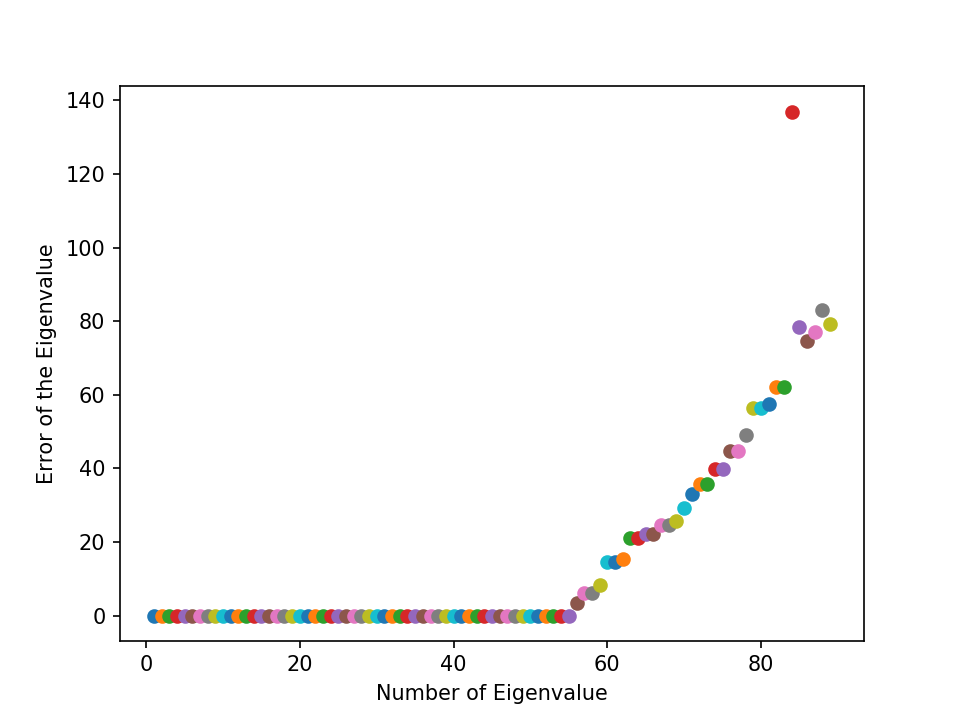

In [160]:
%matplotlib notebook

for k in range(1,int(nr_eigs*0.45)):
    plt.plot(k,abs(exact_arr[k]-lamsquared_1[k]), 'o')

plt.xlabel("Number of Eigenvalue")
plt.ylabel("Error of the Eigenvalue")
plt.show()

In [12]:
def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        A = np.zeros((n,n))
        a = np.random.rand(n)*50
        for j in range(n-1):
            b = np.random.rand(n-j-1)*50
            A = A + np.diag(b,j+1)
        return np.diag(np.random.rand(n-1)*50, -1) + A

In [20]:
def QR_decomp_hesse_1(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):                     #Überprüfen der Bedingung
            t = A[i+1,i]/abs(A[i,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            c = A[i,i]/(abs(A[i,i])*root)                    #Berechnung von c
            s = t/root                                       #Berechnung von s
        else:
            t = A[i,i]/abs(A[i+1,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            s = A[i+1,i]/(abs(A[i+1,i])*root)                #Berechnung von s
            c = t/root                                       #Berechnung von c
            
        for j in range(n):
            if j < i:                                        #Bis zum i-ten Index sind die Einträge a_{i,j} sowie a_{i+1,j} 0
                temp_2 = Q[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j] #Berechnung des neuen Eintrags    
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]            #Berechnung des neuen Eintrags
            else:
                temp_1 = A[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j] #Berechnung der neuen Einträge  
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]   
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]     
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]                                
            
    return Q.T.conj(), A

In [19]:
def runtime(f, A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start

In [139]:
A = gen_hess(500)
M = np.array(A)
L = np.array(A)

In [142]:


q,r = QR_decomp_hesse(L)

print(np.linalg.norm(q@r -M))

4.574689712096618e-12


In [143]:
n_arr = [10*i for i in range(1,40)]

time_1 = [0]*len(n_arr)
error_1 = [0]*len(n_arr)
time_2 = [0]*len(n_arr)
error_2 = [0]*len(n_arr)
mat_arr = []
for i in range(len(n_arr)):
    mat_arr.append(gen_hess(n_arr[i]))

In [145]:
for i in range(len(n_arr)):
    L = np.array(mat_arr[i])
    M = np.array(mat_arr[i])
    q_1, r_1 = QR_decomp_hesse_1(mat_arr[i])
    q_2, r_2 = QR_decomp_hesse(M)
    error_2[i] = np.linalg.norm(r_1@q_1 - r_2@q_2)
    error_1[i] = np.linalg.norm(q_2@r_2 - L)

<IPython.core.display.Javascript object>


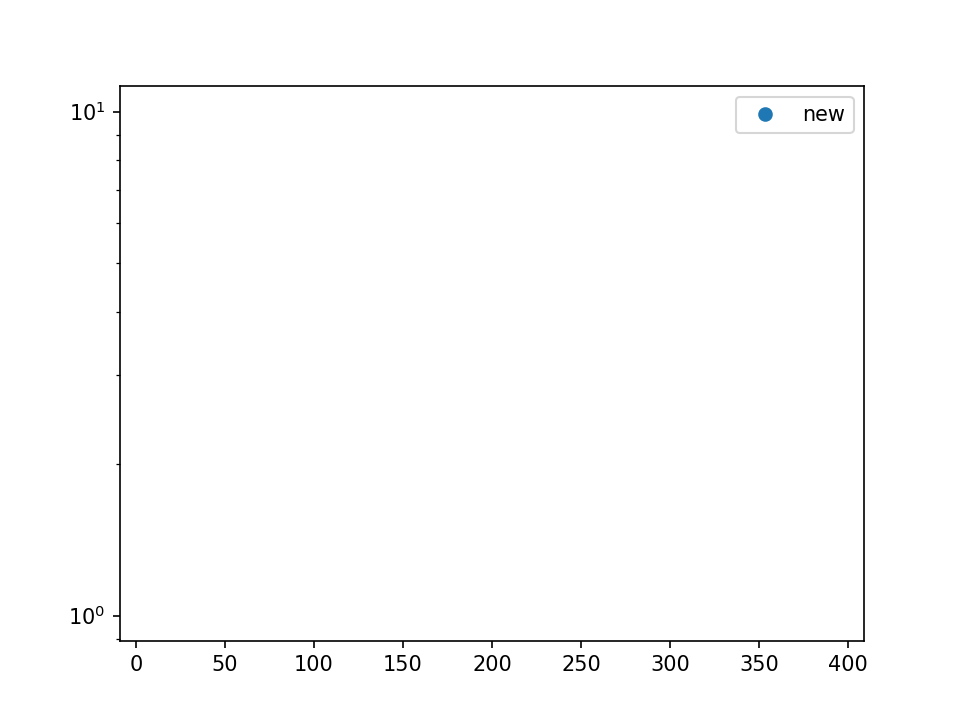

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


In [147]:
%matplotlib notebook

#plt.semilogy(n_arr, error_1, 'o', label = "old")
plt.semilogy(n_arr, error_2, 'o', label = "new")

plt.legend()
plt.show()

In [149]:
print(error_2[34])

0.0
